## Introduction

This project works on real Twitter dataset, and the goal of this project is to detect trending event and retreive corresponding tweets.

### Dataset Setup


The data is preprocessed and organized by date from **2020-03-22** to **2020-08-22**. In each subfolder for each corresponding date, the data files have the following structure.

|Filename|Description|
|---|---|
|DATE_top1000bigrams.csv | Top 1000 bi-grams ordered by counts from the tweets |
|DATE_top1000terms.csv   | Top 1000 terms ordered by counts from the tweets |
|DATE_top1000trigrams.csv| Top 1000 tri-grams ordered by counts from the tweets  |

### Environment Setup


In [1]:
%matplotlib inline
from typing import List, Dict, Optional
from datetime import date, timedelta
from collections import Counter, defaultdict

In [2]:
import json
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [3]:
#download stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zilinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
print (stop_words)

{'with', 'yourself', 'over', 'have', 'while', 'myself', 'is', 'isn', 'out', 'i', "isn't", 'him', 'each', 'very', 'because', 'the', 'most', 'our', 'aren', 'wouldn', "that'll", 'before', 'd', "weren't", 'between', 'only', 'this', 'where', 'through', 'having', 's', 'such', 'both', 'does', 'are', 'his', 'a', 'didn', 'mightn', 'me', 'needn', 'during', 'that', 'an', 'we', 'theirs', 'ma', 'just', 'there', 'ourselves', 'above', 'y', 'they', 'which', 'but', 'themselves', 'ours', 'who', 'can', 've', 'herself', 'nor', "don't", 'mustn', 'was', 'you', 'hadn', 'haven', "you'd", 're', 'then', 'don', 'and', 'am', 'll', 'few', "won't", 'against', 'to', 'no', 'other', 'itself', 'of', 'shouldn', "it's", 'should', 'yourselves', 'at', "hadn't", 'did', 'by', "doesn't", "you'll", "hasn't", 'its', 'do', 'here', 'any', 'when', "needn't", 'down', 'off', 'so', "shan't", 'in', "mustn't", 'm', "haven't", 'will', 'hers', 'those', 'your', "wouldn't", 'them', 'than', 'their', 'until', 'from', "you're", 'again', 'were

In [6]:
custom_stop_words = ['nan',]

In [7]:
stop_words.update(custom_stop_words)

## Data Pre-processing and Exploratory Data Analysis (EDA)

For the word tokens in our dataset, we are going to collect 500 eligible tokens and preprocess the tokens.
- Tokens should be converted to lower case.
- Eligible tokens should have at least 3 characters.
- Eligible tokens should contain alphabet characters or numbers, but not only numbers.
- Eligible tokens should not be stop words.
    

In [8]:
start_dt = date(2020,3,22)
end_dt = date(2020,8,22)

In [9]:
#This counter is used to figure out each token's all time highest count
terms_counter = Counter()
#dict of dictionary, usage: daily_counts[date][token]
daily_counts = defaultdict(dict)
#daily_min_counts is used to track min counts for each token, used to fill missing values later
daily_min_counts = dict()

In [10]:
dt = start_dt
while dt <= end_dt:
    with open(f'./dataset/{dt.isoformat()}/{dt.isoformat()}_top1000terms.csv', 'r') as f:
        for line in f.readlines():
            token, count = line.strip().split(',')
            count = int(count)
            #check eligibility
            token = token.lower()
            if len(token) < 3 or not token.isalnum or token.isdigit() or token in stop_words:
                continue
            
            #Fill the terms_counter, daily_counts and daily_min_couts
            dt_str = dt.isoformat()
            daily_counts[dt_str][token] = count
            daily_min_counts[dt_str] = min(count, daily_min_counts[dt_str]) if dt_str in daily_min_counts else count
            if token not in terms_counter or terms_counter[token] < count:
                terms_counter[token] = count
    
    dt += timedelta(days=1) 
                                                    

In [11]:
print(f'Number of eligible tokens: {len(terms_counter)}')
print(f'Top N tokens with counts:\n{terms_counter.most_common(5)}')

Number of eligible tokens: 4166
Top N tokens with counts:
[('coronavirus', 365236), ('covid', 255660), ('covid19', 248841), ('trump', 75936), ('cases', 60019)]


In [12]:
#select top N words
topN = 100

In [13]:
selected_top_tokens = [x for x, _ in terms_counter.most_common(topN)]

In [14]:
selected_top_tokens[:10]

['coronavirus',
 'covid',
 'covid19',
 'trump',
 'cases',
 'people',
 'amp',
 'new',
 'vaccine',
 'via']

In [40]:
#This timeseries variable is used to store all the tokens and their timeseries in key, value format
timeseries = defaultdict(list)
#ts_idx stores index dates
ts_idx = []

In [41]:
dt = start_dt
while dt <= end_dt:
    dt_str = dt.isoformat()
    ts_idx.append(dt)
    for token in selected_top_tokens:
        timeseries[token].append(daily_counts[dt_str].get(token, daily_min_counts[dt_str]-1))
    dt += timedelta(days=1)

In [42]:
print(ts_idx[:7])
print(len(ts_idx))

[datetime.date(2020, 3, 22), datetime.date(2020, 3, 23), datetime.date(2020, 3, 24), datetime.date(2020, 3, 25), datetime.date(2020, 3, 26), datetime.date(2020, 3, 27), datetime.date(2020, 3, 28)]
154


In [43]:
print(timeseries['covid'])

[67037, 84031, 91123, 90652, 128786, 134682, 116419, 116988, 139430, 146153, 145358, 146368, 148479, 146388, 147042, 164911, 168594, 176088, 186855, 172071, 153534, 167386, 202958, 200246, 194092, 212290, 188075, 174264, 186944, 202177, 224951, 255660, 212241, 193133, 186974, 202960, 219733, 225712, 237720, 232681, 169041, 193697, 203800, 227738, 226726, 238683, 243692, 252701, 236785, 189520, 226871, 243658, 226747, 251465, 251029, 216289, 194643, 206824, 201255, 199509, 246092, 241074, 194693, 188803, 216674, 246165, 253685, 226260, 225451, 185472, 175614, 201258, 219113, 224508, 218070, 209458, 171276, 162570, 213864, 216173, 212951, 230501, 208480, 160232, 150398, 210797, 224025, 224189, 215140, 213987, 178016, 152390, 209028, 221034, 204587, 221829, 211967, 183500, 166035, 215507, 203613, 218067, 212170, 206981, 164436, 181446, 214526, 238524, 220280, 223908, 219880, 155299, 178734, 218255, 227139, 211307, 227539, 217091, 163477, 165303, 219258, 220434, 225435, 219940, 204673, 153

Plot function for visualizing the timeseries for each token

In [44]:
def plot_ts(ts: List[float], labels: List[str] = None) -> None:
    if not labels:
        labels = list(range(len(ts)))
    plt.plot(labels, ts)
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("# of appearance")
    plt.show()

def token_trend(token: str):
    plot_ts(timeseries[token])

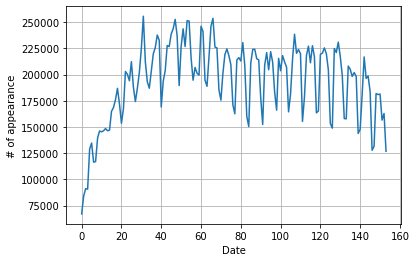

In [45]:
token_trend('covid')

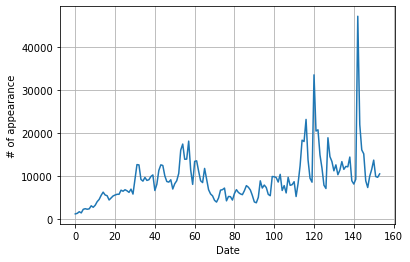

In [46]:
token_trend('vaccine')

## Anomaly Detection Algorithm Implementation

This project implements the Seasonal Hybrid ESD algorithm from Twitter

### Seasonal Trend Decomposition

In [47]:
import numpy as np
import statsmodels.api as sm
from statsmodels.robust.scale import mad
from scipy.stats import t as student_t

In [48]:
#seasonal trend decomposition function
def stl(timeseries: np.ndarray, period: int):
    decomp = sm.tsa.seasonal_decompose(timeseries, period=period)
    return decomp.seasonal, decomp.trend, decomp.resid

Example: decompose the timeseries for 'covid'

In [49]:
seasonal, trend, resid = stl(np.array(timeseries['covid']), period=7)

Original Timeseries


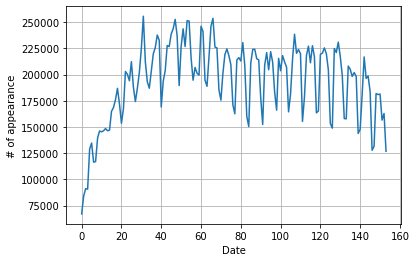

Seasonal Component


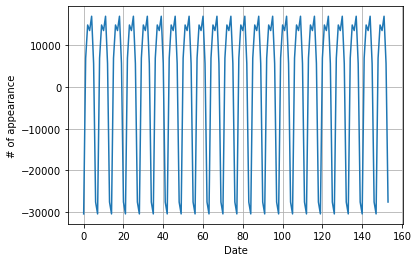

Trend Component


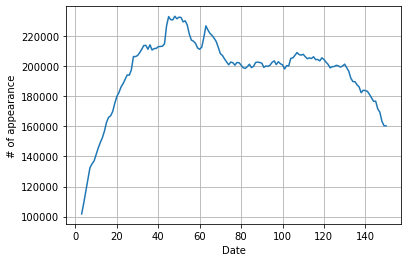

Residual Component


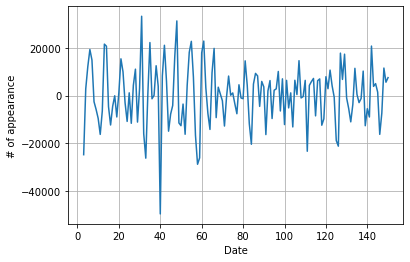

In [50]:
print('Original Timeseries')
plot_ts(timeseries['covid'])
print('Seasonal Component')
plot_ts(seasonal)
print('Trend Component')
plot_ts(trend)
print('Residual Component')
plot_ts(resid)

### Robust Extreme Studentized Deviate (ESD) Test Algorithm

#### Test statistics
In Robust ESD test, we first define the maximum number of anomalies $K$, and then compute the following test statistic for the $k=1,2,...,K$ most extreme values in the data set:

$$
C_k=\frac{\max_k |x_k-\tilde{x}|}{\hat{\sigma}}
$$

where $\tilde{x}$ is the median of the series and $\hat{\sigma}$ is the median absolute deviation (MAD), which is defined as $\text{MAD} = \text{median}(|X-\text{median}(X)|)$.

Note: MAD can be calculated using the mad function from statsmodels (i.e., `from statsmodels.robust.scale import mad`)

#### Critical value
The test statistic is then used to compare with a critical value, which is computed using following equation:

$$
\lambda_k=\frac{(n-k) t_{p,\ n-k-1}}{\sqrt{(n-k-1+t_{p,\ n-k-1}^2)(n-k+1)}}
$$

#### Anomaly direction
To determine the direction of anomaly, we use the sign of the $|x_k-\tilde{x}|$ in $C_k$. If sign is positive, then the anomaly is greater than median and it's very likely to be a spike, otherwise, it should be a dip.

In [56]:
def robust_seasonal_esd_test(ts, max_anom=5, seasonal=False, period=None, alpha=0.05, threshold=1.0):
    """Robust Seasonal Extreme Studentized Deviate Test"""
    series = np.copy(ts)
    if len(ts) != len(ts_idx):
        print(f"Bad timeseries, length={len(ts)}")
        return []
    
    # Implement the seasonal decomposition as an option
    if seasonal:
        if not period:
            raise RuntimeError("Period must be set if the time series is seasonal")
        # remove the seasonal signal and median (based on the paper)
        seasonal, _, _ = stl(series, period)
        series = series - seasonal - np.median(series)
        
    
    N = len(series)
    ts_index = np.array(range(N))
    
    anom_list = []
    n_anom = 0
    for k in range(1, max_anom+1):
        
        # Compute the test statistic C_k
        s_ori = series - np.median(series)
        s = np.absolute(s_ori)
        sigma_hat = mad(series)
        if sigma_hat == 0:
            break
        s /= sigma_hat
        max_idx = np.argmax(s)
        C_k = s[max_idx]
        
        # determine the direction or anomaly
        direction = 'Up' if s_ori[max_idx] >= 0 else 'Down'
        
        # Compute the critical value
        p = 1 - alpha / (2 * (N - k + 1))
        t = student_t.ppf(p, N - k - 1)
        lambda_k = (N-k) * t / np.sqrt((N-k-1-t**2) * (N-k+1) )

        # The score is defined as C_k / lambda_k, if the score > threshold,
        # we take this data point as an anomaly
        score = C_k / lambda_k
        if score > threshold:
            n_anom = k
        else:
            break
        
        anom_list.append({
            "rank": k,
            "index": int(ts_index[max_idx]),
            "value": float(ts[ts_index[max_idx]]),
            "direction": direction,
            "score": round(score, 2)
        })
            
        # Remove the identified value from both time-series and index
        series = np.delete(series, max_idx)
        ts_index = np.delete(ts_index, max_idx)
    return anom_list

In [57]:
def plot_anomaly_on_ts(ts: List[float], anom_index_list: List[int], anom_value_list: List[int]) -> None:
    """
    Plot timeseries chart together with detected anomalies as scatter points
    ts:
        The values of timeseries
    
    anom_index_list:
        The list of timeseries index for the detected anomalies, for instance, if the 2nd data point
        is identified as anomaly, the index will be 1 (since it starts from 0)
    
    anom_value_list:
        The list of values for the detected anomalies
    """
    labels = list(range(len(ts)))
    plt.plot(labels, ts)
    plt.scatter(anom_index_list, anom_value_list, s=50.0, c='red')
    plt.grid()
    plt.xlabel('date')
    plt.ylabel('# of appearance')
    plt.show()

def pretty_print(struct):
    """
    struct:
        The struct can be anything that is JSON serializable, like dictionary, or list.
    """
    print(json.dumps(struct, indent=2))

In [58]:
len(ts_idx), len(timeseries['covid'])

(154, 154)

[
  {
    "rank": 1,
    "index": 142,
    "value": 47077.0,
    "direction": "Up",
    "score": 2.52
  },
  {
    "rank": 2,
    "index": 120,
    "value": 33480.0,
    "direction": "Up",
    "score": 1.72
  },
  {
    "rank": 3,
    "index": 116,
    "value": 23138.0,
    "direction": "Up",
    "score": 1.04
  }
]


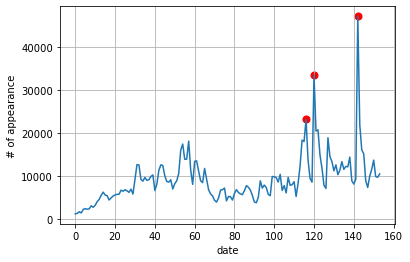

In [60]:
ts = np.array(timeseries['vaccine'])
anom_list = robust_seasonal_esd_test(ts, threshold=1.0)
pretty_print(anom_list)

# for our use case, we should only keep anomalies going up
anom_index = [anom['index'] for anom in anom_list]
anom_value = [anom['value'] for anom in anom_list]

plot_anomaly_on_ts(ts, anom_index, anom_value)

## Trending Event Detection using Anomaly Detection

### Apply Anomaly Detection and Group Keywords

In [61]:
# We will use this dict to remember the anomalous token for each date
# format: daily_anom_tokens[date_string][anomalous_token] = anom_dict_from_the_algorithm
daily_anom_tokens = defaultdict(dict)

In [64]:
all_tokens = timeseries.keys()

for token in all_tokens:
    # apply anomaly detection for the timeseries of all tokens.
    # Notice we only want anomaly with direction going "Up"
    ts = np.array(timeseries[token])
    token_anom_list = robust_seasonal_esd_test(ts, threshold=1.1)
    for anom in token_anom_list:
        if anom['direction'] != 'Up':
            continue
        date = ts_idx[anom['index']]
        daily_anom_tokens[date][token] = anom

In [65]:
# print out the trending keywrods (i.e., the anomalous tokens) 
# identified for each date

for date in sorted(daily_anom_tokens.keys()):
    key_tokens = daily_anom_tokens[date].keys()
    #1. add the score for its token to create (token, score) tuple
    #2. sort the token for each date by score (descending)
    ordered_tokens = [(token, daily_anom_tokens[date][token]['score']) for token in key_tokens]
    ordered_tokens.sort(key=lambda x:x[1])
    
    # Here we print the token along with its score in descending order
    print(date)
    for token, score in ordered_tokens:
        space = ' '*(27-len(token))
        print(f'{token}{space}{score}')
    print()

2020-03-22
coronaviruspandemic        3.12

2020-03-26
coronaviruspandemic        2.11
covid2019                  9.33

2020-03-27
covid2019                  6.92

2020-03-31
memerangi                  1.54
dalam                      2.45

2020-04-01
covidー19                   2.28

2020-04-03
coronaviruspandemic        3.51

2020-04-04
coronaviruspandemic        4.23
covid2019                  8.94

2020-04-05
coronaviruspandemic        3.65
covid2019                  6.45

2020-04-06
covid_19                   1.29

2020-04-09
dan                        1.95
easter                     2.53
kita                       3.87
untuk                      4.26
penyebaran                 4.46

2020-04-10
covidー19                   2.19
easter                     5.24

2020-04-11
easter                     7.41

2020-04-12
support                    1.53
easter                     22.24

2020-04-13
support                    1.36
easter                     4.01
covid2019                  8.36
